In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
from pprint import pprint
from datetime import datetime
import os
import csv

In [2]:
yr = 2017
fire_gdf = gpd.read_file(f'../outputs/geojson/clean/ca_fire_{yr}.geojson').set_crs(4326)
fire_gdf.head()

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,AGENCY,FIRE_NAME,geometry
0,2017-05-23,2017-05-24,14,Unknown/Unidentified,10.043820,CCO,BROOK,"POLYGON ((-118.84543 34.13450, -118.84520 34.1..."
1,2017-09-09,2017-09-09,14,Unknown/Unidentified,1.190109,CCO,PACIFIC,"POLYGON ((-119.35801 34.33982, -119.35822 34.3..."
2,2017-07-04,2017-07-05,14,Unknown/Unidentified,47.194030,CCO,GRADE,"POLYGON ((-118.97860 34.20478, -118.97845 34.2..."
3,2017-06-24,2017-06-24,14,Unknown/Unidentified,1.158548,CCO,PACIFICA,"POLYGON ((-118.84282 34.12987, -118.84271 34.1..."
4,2017-05-15,2017-05-15,14,Unknown/Unidentified,2.893327,CCO,MONTVIEW,"POLYGON ((-118.84409 34.13437, -118.84413 34.1..."


In [3]:
columns_to_drop = ['FIRE_NAME', 'AGENCY', 'geometry']
fire_gdf.drop(columns=columns_to_drop, inplace=True)

In [4]:
fire_gdf.head()

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES
0,2017-05-23,2017-05-24,14,Unknown/Unidentified,10.043820
1,2017-09-09,2017-09-09,14,Unknown/Unidentified,1.190109
2,2017-07-04,2017-07-05,14,Unknown/Unidentified,47.194030
3,2017-06-24,2017-06-24,14,Unknown/Unidentified,1.158548
4,2017-05-15,2017-05-15,14,Unknown/Unidentified,2.893327


In [5]:
fire_gdf['CONT_DATE'] = pd.to_datetime(fire_gdf['CONT_DATE'])
fire_gdf['ALARM_DATE'] = pd.to_datetime(fire_gdf['ALARM_DATE'])
fire_gdf['Duration'] = fire_gdf['CONT_DATE'] - fire_gdf['ALARM_DATE']

In [6]:
fire_gdf.head()

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,Duration
0,2017-05-23,2017-05-24,14,Unknown/Unidentified,10.043820,1 days
1,2017-09-09,2017-09-09,14,Unknown/Unidentified,1.190109,0 days
2,2017-07-04,2017-07-05,14,Unknown/Unidentified,47.194030,1 days
3,2017-06-24,2017-06-24,14,Unknown/Unidentified,1.158548,0 days
4,2017-05-15,2017-05-15,14,Unknown/Unidentified,2.893327,0 days


In [7]:
average_duration = []
average_acres = []
cause_df = fire_gdf.sort_values(by='CAUSE_ID').reset_index()
def average_calc(i, df):
    test_df = df.loc[df['CAUSE_ID'] == i]
    days = []
    for d in test_df['Duration']:
        days.append(d.days)
    if len(days) != 0:
        average_d = round(sum(days)/len(days), 2)
    else:
        average_d = 0
    average_a = round(test_df['GIS_ACRES'].mean(),2)
    return average_d, average_a

for i in cause_df['CAUSE_ID'].unique():
    d, a = average_calc(i, cause_df)
    average_duration.append(d)
    average_acres.append(a)
cause_list = cause_df['CAUSE'].unique()
cause_df.head()

,index,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,Duration
0,605,2017-07-27,2017-08-30,1,Lightning,4665.48500,34 days
1,235,2017-09-12,2017-09-23,1,Lightning,10.83091,11 days
2,486,2017-07-26,2017-09-11,1,Lightning,254.88580,47 days
3,485,2017-07-25,2017-09-06,1,Lightning,30890.86000,43 days
4,484,2017-07-24,2017-07-29,1,Lightning,29.35282,5 days


In [8]:
counts = cause_df.groupby('CAUSE_ID').size()
source_df = pd.DataFrame({'Causes' : cause_list, 
                          'Average Duration (days)' : average_duration, 
                          'Average GIS Acres' : average_acres,
                          'Number of Occurences (in the Year)' : counts})
source_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
CAUSE_ID,,,,
1,Lightning,35.48,3336.84,133
2,Equipment Use,3.60,550.16,57
3,Smoking,3.00,11.93,1
4,Campfire,2.15,64.42,13
5,Debris,1.53,768.57,15
7,Arson,4.48,1874.15,27
8,Playing with fire,0.75,9.37,4
9,Miscellaneous,9.45,5179.99,83
10,Vehicle,6.11,3775.74,47


In [9]:
source_clean_df = source_df.drop(index = [9,14], inplace = False)
source_clean_df.to_csv("outputs/fire_source_2017.csv",
                  encoding="utf-8", index=False, header=True)
source_clean_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
CAUSE_ID,,,,
1,Lightning,35.48,3336.84,133
2,Equipment Use,3.60,550.16,57
3,Smoking,3.00,11.93,1
4,Campfire,2.15,64.42,13
5,Debris,1.53,768.57,15
7,Arson,4.48,1874.15,27
8,Playing with fire,0.75,9.37,4
10,Vehicle,6.11,3775.74,47
11,Powerline,4.50,496.72,32


In [10]:
man_duration = 0
man_GIS_acres = 0
man_oc = 0
nat_duration = 0
nat_GIS_acres = 0
nat_oc = 0
for index, row in source_clean_df.iterrows():
    if row['Causes'] == 'Lightning':
        nat_duration += row['Average Duration (days)']
        nat_GIS_acres += row['Average GIS Acres']
        nat_oc += row['Number of Occurences (in the Year)']
    else:
        man_duration += row['Average Duration (days)'] 
        man_GIS_acres += row['Average GIS Acres']
        man_oc += row['Number of Occurences (in the Year)']

man_vs_nature_df = pd.DataFrame({'Causes':['Man-Made', 'Natural'], 
                                 'Average Duration (days)': [man_duration, nat_duration], 
                                 'Average GIS Acres': [man_GIS_acres, nat_GIS_acres],
                                 'Number of Occurences (in the Year)':[man_oc, nat_oc]
                                })
man_vs_nature_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
0,Man-Made,26.12,7551.06,196
1,Natural,35.48,3336.84,133


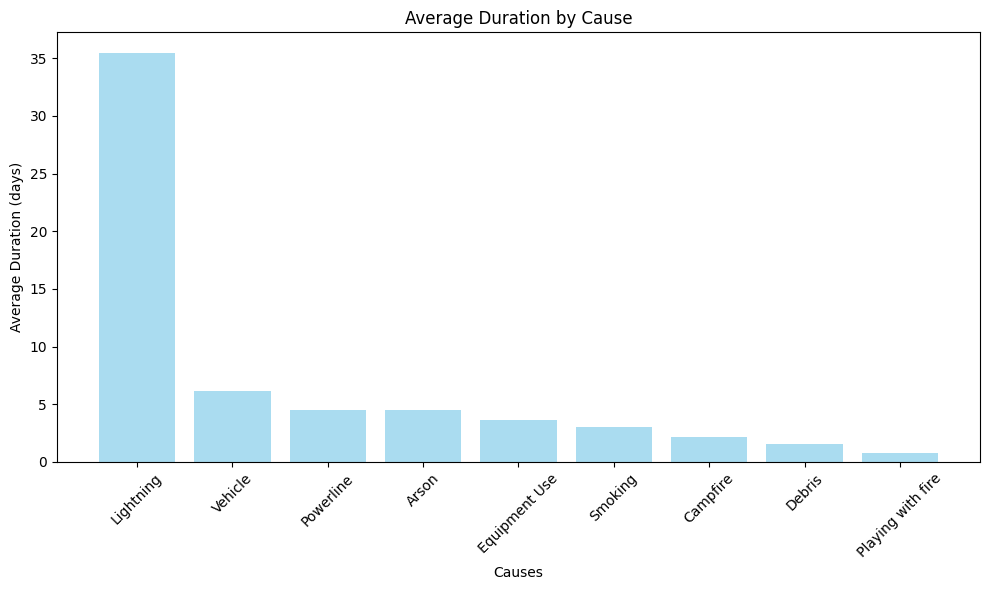

In [11]:
source_clean_df = source_clean_df.sort_values(by='Average Duration (days)', ascending=False)
plt.figure(figsize=(10, 6))

plt.bar(source_clean_df['Causes'], source_clean_df['Average Duration (days)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average Duration (days)')
plt.title('Average Duration by Cause')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

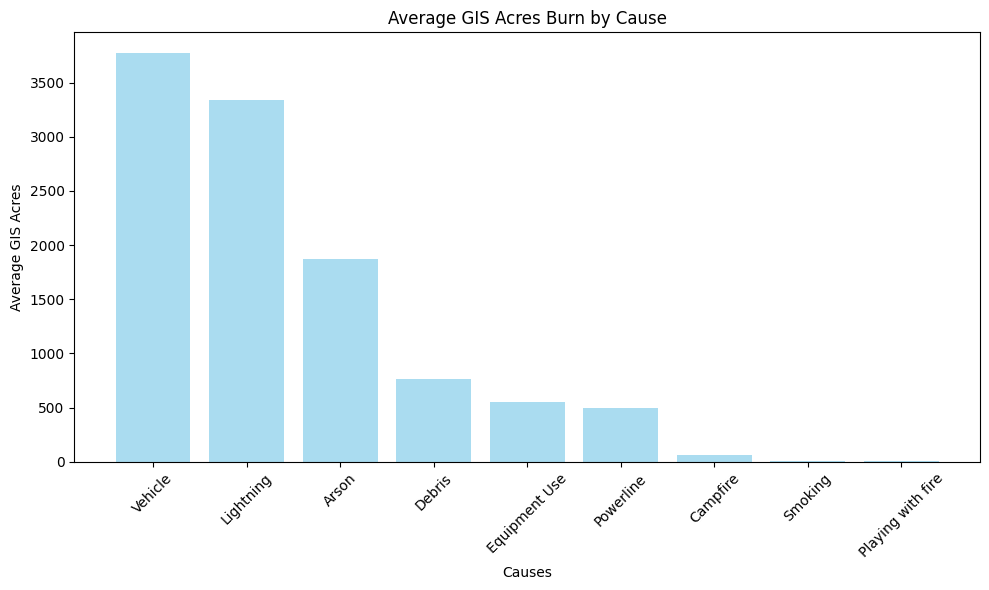

In [12]:
source_clean_df = source_clean_df.sort_values(by='Average GIS Acres', ascending=False)
plt.figure(figsize=(10, 6))

plt.bar(source_clean_df['Causes'], source_clean_df['Average GIS Acres'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average GIS Acres')
plt.title('Average GIS Acres Burn by Cause')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

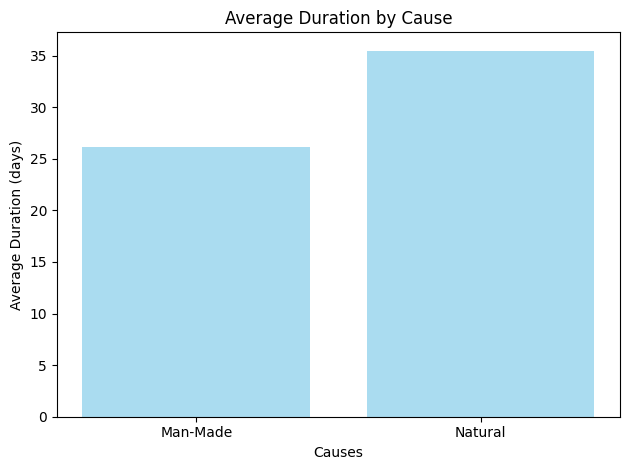

In [13]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Average Duration (days)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average Duration (days)')
plt.title('Average Duration by Cause')

plt.tight_layout()
plt.show()

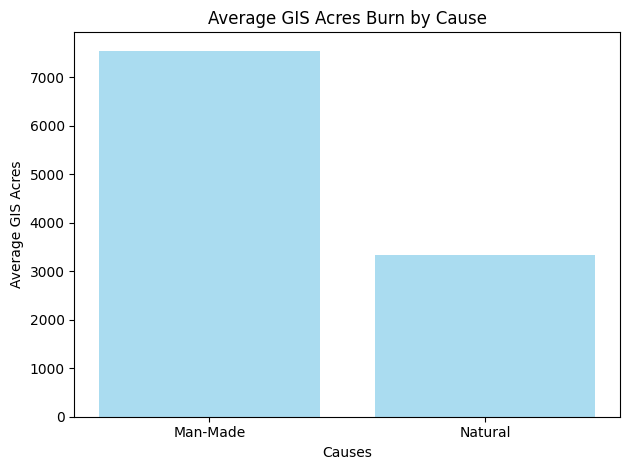

In [14]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Average GIS Acres'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average GIS Acres')
plt.title('Average GIS Acres Burn by Cause')

plt.tight_layout()
plt.show()

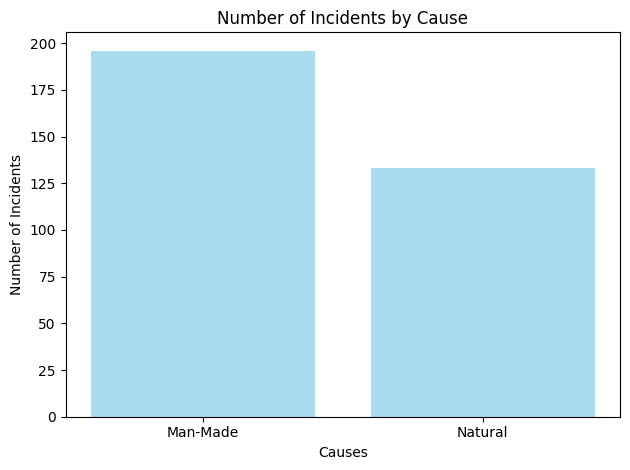

In [15]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Number of Occurences (in the Year)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Number of Incidents')
plt.title('Number of Incidents by Cause')

plt.tight_layout()
plt.show()

In [25]:
fire_gdf.sort_values(by='Duration')

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,Duration
422,2017-09-27,2017-08-29,7,Arson,113.05440,-29 days
302,2017-10-28,2017-10-28,14,Unknown/Unidentified,28.04709,0 days
450,2017-07-10,2017-07-10,9,Miscellaneous,0.12901,0 days
205,2017-06-22,2017-06-22,14,Unknown/Unidentified,43.80302,0 days
204,2017-07-15,2017-07-15,14,Unknown/Unidentified,15.62878,0 days
...,...,...,...,...,...,...
395,2017-08-20,2018-01-15,1,Lightning,48.38200,148 days
592,2017-08-10,2018-01-09,1,Lightning,32893.26000,152 days
516,2017-03-08,2017-08-08,10,Vehicle,53.36273,153 days
405,2017-08-12,2018-01-15,1,Lightning,31.87081,156 days


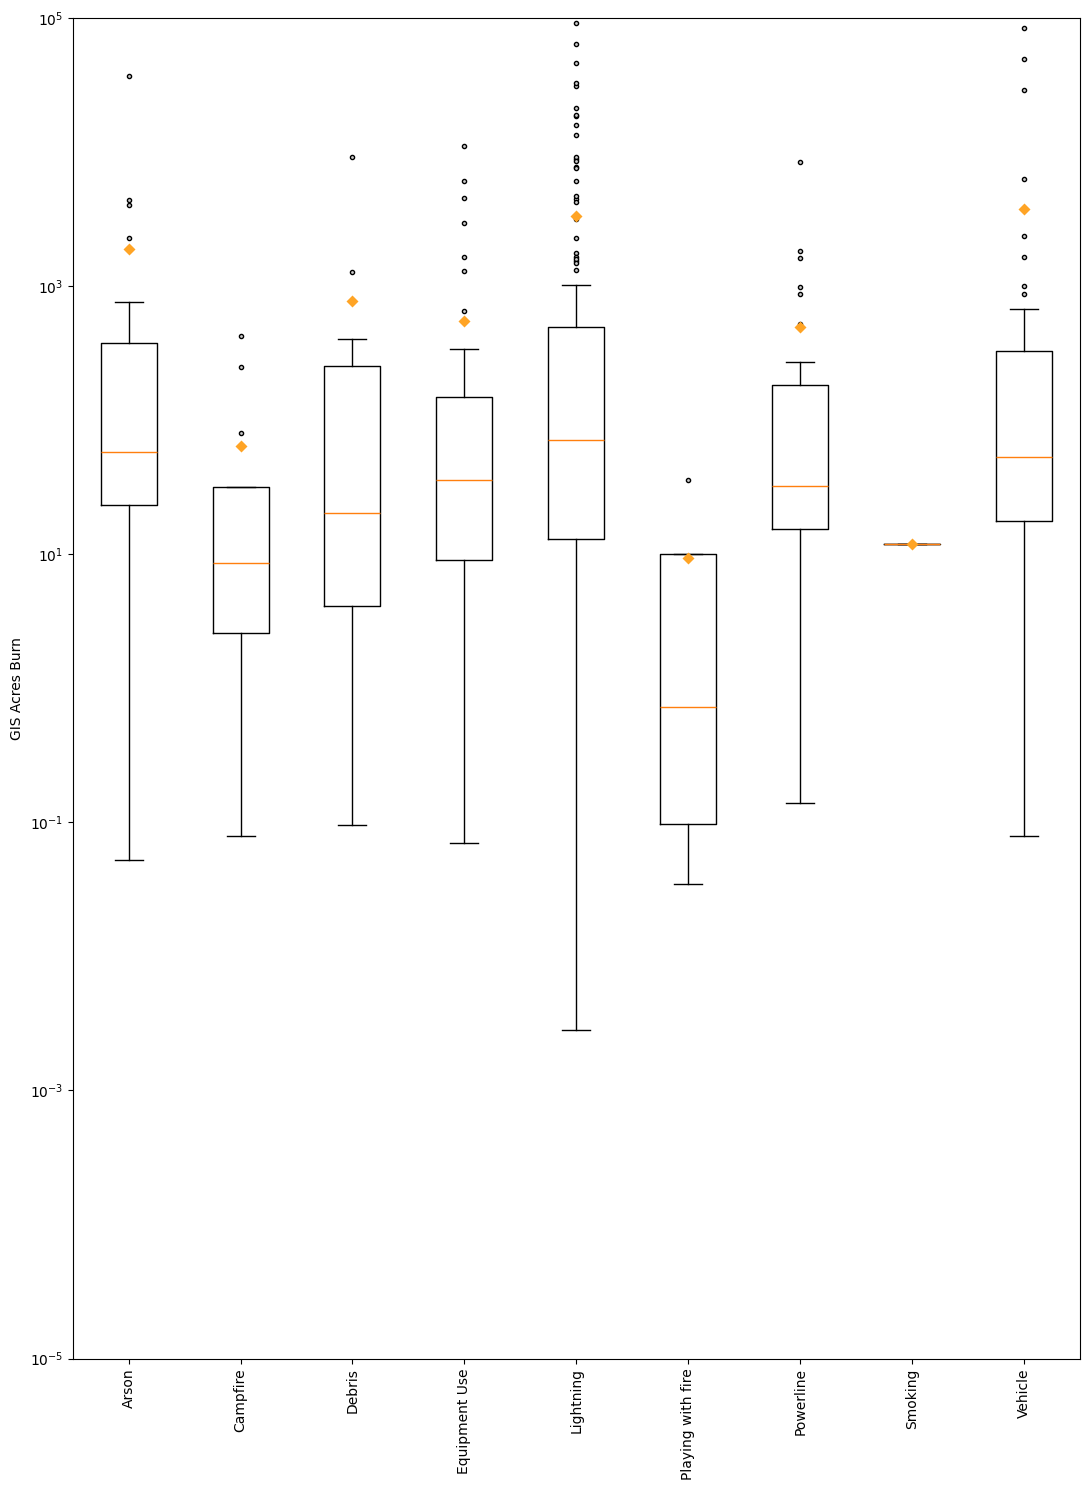

In [24]:
cause_list = fire_gdf['CAUSE'].unique()
value_to_remove = 'Miscellaneous'
new_arr = cause_list[cause_list != value_to_remove]
value_to_remove = 'Unknown/Unidentified'
cause_list = new_arr[new_arr != value_to_remove]
cause_gis = fire_gdf[fire_gdf['CAUSE'].isin(cause_list)]
grouped_data = cause_gis.groupby('CAUSE')['GIS_ACRES'].apply(list)

# # Create a box plot
# Highlight potential outliers by changing their color or style
plt.figure(figsize=(11,15))
meanprops = dict(marker='D', markeredgecolor='none',markerfacecolor='#ffa425')
plt.boxplot(grouped_data.values, tick_labels=grouped_data.index, showfliers=True, patch_artist=False, 
            flierprops=dict(marker='o', markerfacecolor='#ccc', markersize=3), meanprops = meanprops,showmeans = True
)

# Add labels and title
plt.ylim(0.00001, 100000)
plt.xticks(rotation=90)
plt.ylabel('GIS Acres Burn')
plt.yscale('log')
plt.tight_layout()
plt.show()